<a href="https://colab.research.google.com/github/henryyockey/ZZto4e/blob/main/ZZto4e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ZZ->4e Data##


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape, Layer, BatchNormalization, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers


import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt


In [ ]:
n_max = 3000
batch_size=16

In [ ]:
!mkdir data/

In [ ]:
!wget https://cernbox.cern.ch/index.php/s/UX6scYU0MaKJSmq/download -O data/data.tar.gz

--2022-05-03 15:54:36--  https://cernbox.cern.ch/index.php/s/UX6scYU0MaKJSmq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.170.17, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2000134942 (1.9G) [application/gzip]
Saving to: ‘data/data.tar.gz’

data/data.tar.gz    100%[===================>]   1.86G  25.5MB/s    in 74s     

Last-modified header invalid -- time-stamp ignored.
2022-05-03 15:56:05 (25.8 MB/s) - ‘data/data.tar.gz’ saved [2000134942/2000134942]



In [ ]:
%cd data/
!tar -xf data.tar.gz
%cd ..

/content/data
/content


In [ ]:
# removes events above or below a certain threshhold of nonzero channel readouts
# the choice is arbitrary but if you don't trim the data, colab runs out of ram

def trim_data(limit = n_max):
  c = 0
  h = []
  for filename in os.listdir('/content/data/data'):
    with open('/content/data/data/'+filename) as f: l = sum(1 for line in f)
    h.append(l)
    if l > limit:
      os.remove('/content/data/data/'+filename)
      c+=1
  print('%i events removed.'%c)
  return h

In [ ]:
hist = trim_data()

7815 events removed.


13237


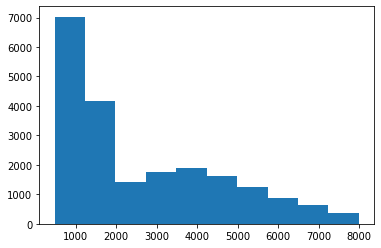

In [ ]:
hist.sort()
plt.hist(hist)

print(len(os.listdir('/content/data/data/')))


In [ ]:
# load data one batch at a time

file_list = [file for file in os.listdir('/content/data/data')]

def load_X_event(filename, cyl = False):
  cols = (5,6,7,8) if cyl else (2,3,4,8)
  feat = 4
  X = genfromtxt('/content/data/data/%s' %filename, usecols=cols, delimiter=',')
  n = X.shape[0]
  nfill = n_max-n
  X_fill = np.zeros((nfill, feat, 1))
  X = np.concatenate((X.reshape((n, feat, 1)), X_fill))
  return X.transpose(2,0,1)

def load_y_event(filename, isCat=True):
  cols = (9)
  feat = 1
  y = genfromtxt('/content/data/data/%s' %filename, usecols=cols, delimiter=',')
  n = y.shape[0]
  nfill = n_max-n
  y_fill = np.zeros((nfill, feat, 1))+4
  y = np.concatenate((y.reshape((n, feat, 1)), y_fill))
  y = y.transpose(2,0,1).reshape(-1,n_max)
  for i in range(y.shape[0]):
    for j in range(y.shape[1]):
      # jets = 0
      # fill = 4
      if y[i][j] == -11: y[i][j] = 1 # positrons
      elif y[i][j] == 11: y[i][j] = 2  # electrons
      else : y[i][j] = 3 # background
  if isCat: y = to_categorical(y, num_classes= 5)
  return y

def loadBatch_X(files):
  X = np.concatenate([load_X_event(f) for f in files], axis=0)
  return X

def loadBatch_y(files):
  y = np.concatenate([load_y_event(f, isCat=True) for f in files], axis=0)
  return y

# Generator that loads one batch at a time
def BatchLoader(files, batch_size):

    L = len(files)

    #this line is just to make the generator infinite, keras needs that
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = loadBatch_X(files[batch_start:limit])
            y = loadBatch_y(files[batch_start:limit])

            yield (X,y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [ ]:
file_list = [file for file in os.listdir('/content/data/data')]

training_files, test_files = train_test_split(file_list, test_size = 0.2)
training_files, validation_files = train_test_split(training_files, test_size = 0.2)

training_generator = BatchLoader(training_files, batch_size)
validation_generator = BatchLoader(validation_files, batch_size)
test_generator = BatchLoader(test_files, 1)

## Defining custom Layers ##



In [ ]:
def conv_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

def transformation_net(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=tf.keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

In [ ]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
  union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
from sklearn.model_selection import train_test_split
def WeightedCategoricalCrossentropy(y_true, y_pred):
  #y_true (3000, 5)
  # e+- 2.5%
  # jets 21.3
  # background 44.7 %
  # fill 29%

  min_class = 0
  min_val = np.inf
  for x in range(5):
    if K.all(K.sum(y_true[:,x],axis=0) <= min_val):
      min_class = x
      min_val = K.sum(y_true[:,x],axis=0)
      print(K.eval(min_val))

  # if np.sum(y_true[:,1],axis=0) <= np.sum(y_true[:,2],axis=0):
  #   min_class = 0
  # else:
  #   min_class = 1
  base_len = min_val#keras.sum(y_true[:,min_class],axis=0)

  # jets_true = K.where(y_true[:,0]==1)[0]
  # positron_true = K.where(y_true[:,1]==1)[0]
  # electron_true = K.where(y_true[:,2]==1)[0]
  # bkg_true = np.where(y_true[:,3]==1)[0]
  # fill_true = np.where(y_true[:,4]==1)[0]
  # a[np.where(a==1)[0]]
  y_true_prime = []
  y_pred_prime = []
  for x in range(5):
    # np.random.choice(np.where(y_true[:,x]==1)[0], base_len)
    total_indices = tf.where(y_true[:,x]==1)[0]
    print(min_val)
    print(len(total_indices))
    print(tf.random.shuffle(total_indices)[:min_val])
    index_instance = tf.random.shuffle(total_indices)[:min_val]
    y_true_prime.append(y_true[index_instance])
    y_pred_prime.append(y_pred[index_instance])
    # y_true_prime.append(y_true[K.random.choice(tf.where(y_true[:,x]==1)[0],base_len)])
  y_true_prime = tf.stack(y_true_prime)
  y_pred_prime = tf.stack(y_pred_prime)

  # randomly sample y_true to equally weight classes

  cce = tf.keras.losses.CategoricalCrossentropy()
  return cce(y_true_prime, y_pred_prime)


## Model ##

In [ ]:
def get_shape_segmentation_model(num_points: int, num_classes: int) -> tf.keras.Model:
    input_points = tf.keras.Input(shape=(None, 4))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=4, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = tf.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return tf.keras.Model(input_points, outputs)

In [ ]:
file_list = [file for file in os.listdir('/content/data/data')]
bl = BatchLoader(file_list, batch_size)
x,y = next(bl)
num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 4)]    0           []                               
                                                                                                  
 input_transformation_block_1_c  (None, None, 64)    320         ['input_1[0][0]']                
 onv (Conv1D)                                                                                     
                                                                                                  
 input_transformation_block_1_b  (None, None, 64)    256         ['input_transformation_block_1_co
 atch_norm (BatchNormalization)                                  nv[0][0]']                       
                                                                                              

In [ ]:
def run_experiment(epochs):

    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(), #WeightedCategoricalCrossEntropy
        metrics=[iou_coef],
    )

#    checkpoint_filepath = "/tmp/checkpoint"
#    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#        checkpoint_filepath,
#        monitor="val_loss",
#        save_best_only=True,
#        save_weights_only=True,
#    )
    file_list = [file for file in os.listdir('/content/data/data')]
    history = segmentation_model.fit(
        training_generator,
        epochs=epochs,
        validation_data = validation_generator,
        validation_steps=100,
        steps_per_epoch= len(training_files) // batch_size,
        #callbacks=[checkpoint_callback],
    )

#    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


In [ ]:
#tf.config.run_functions_eagerly(True)
segmentation_model, history = run_experiment(epochs=3)

NameError: ignored

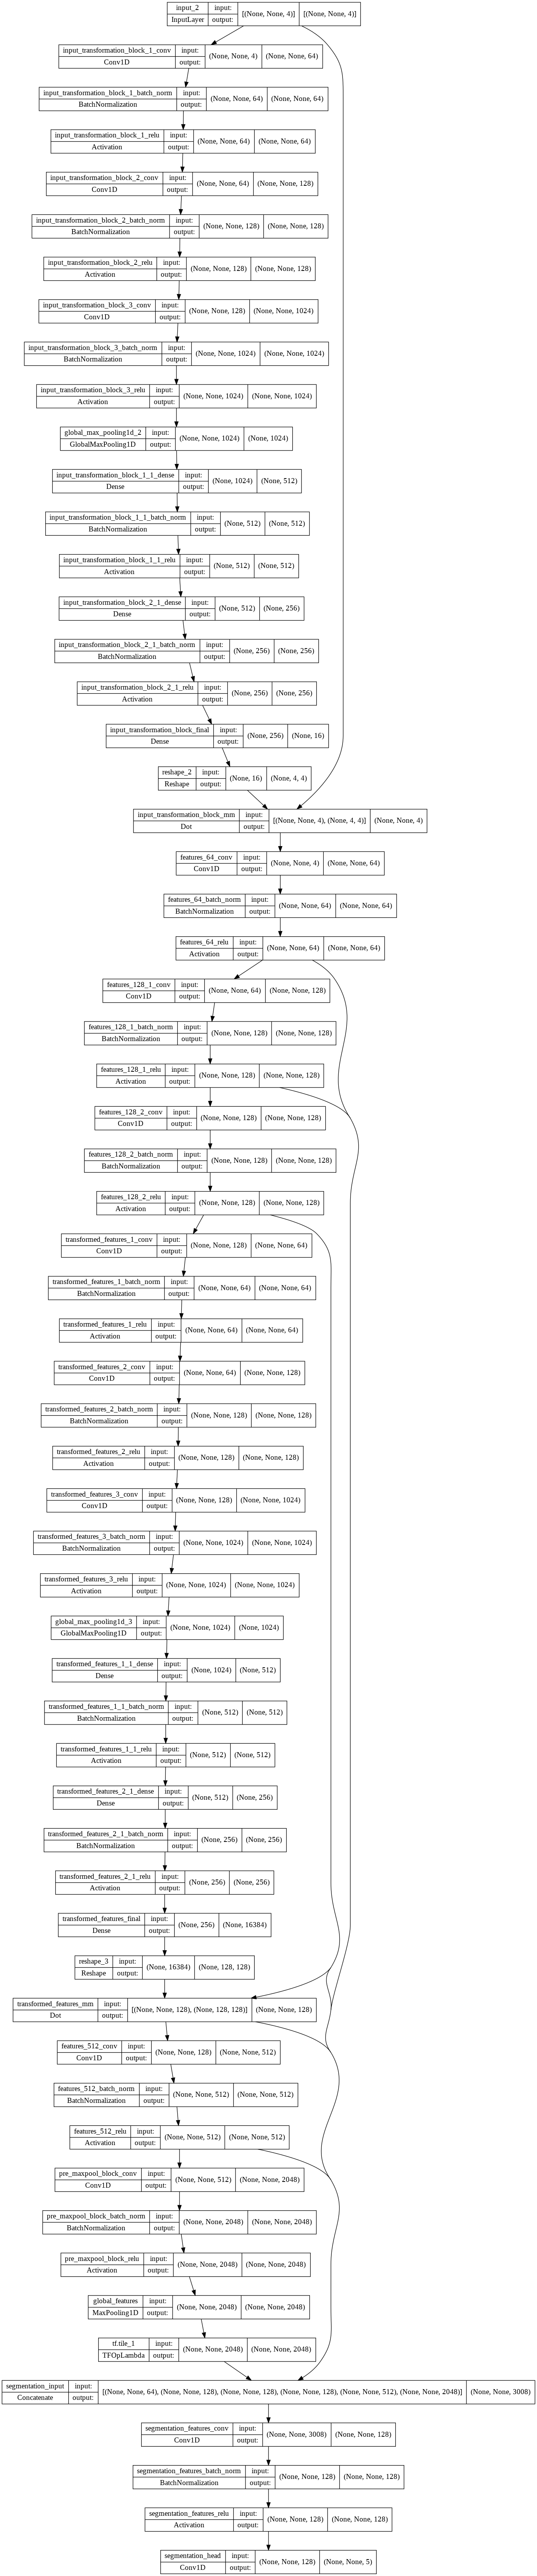

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(segmentation_model, show_shapes=True)

In [ ]:
# save model to drive
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import keras
from keras.layers import Embedding

In [ ]:
categoric_input = keras.Input(shape=(1,), name='cat_in')
embedding = Embedding(5, 3, input_length=1, name='embed')(categoric_input)
embedding = keras.layers.Flatten()(embedding)
Num_in = []
Num_Embed = []
for i in range(18):
    num_in = keras.Input(shape=(1,), name='num_in{}'.format(i))
    Num_in.append(num_in)
    num_embed = keras.layers.Concatenate()([num_in, embedding])
    num_embed = Dense(3, activation='relu', kernel_initializer='GlorotNormal')(num_embed)
    Num_Embed.append(num_embed)

out = keras.layers.Concatenate()(Num_Embed)
hidden_layers = [128,64,8]
for n_hidden in hidden_layers:
    out = Dense(n_hidden, activation='relu', kernel_initializer='GlorotNormal')(out)
    out = Dropout(0.2)(out)

out = Dense(1, activation='sigmoid',kernel_initializer='GlorotNormal')(out)


In [ ]:
model2 = keras.Model(
    inputs = [Num_in, categoric_input],
    outputs = out,
)
model2.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model2.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cat_in (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 embed (Embedding)              (None, 1, 3)         15          ['cat_in[0][0]']                 
                                                                                                  
 num_in0 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 flatten (Flatten)              (None, 3)            0           ['embed[0][0]']                  
                                                                                              

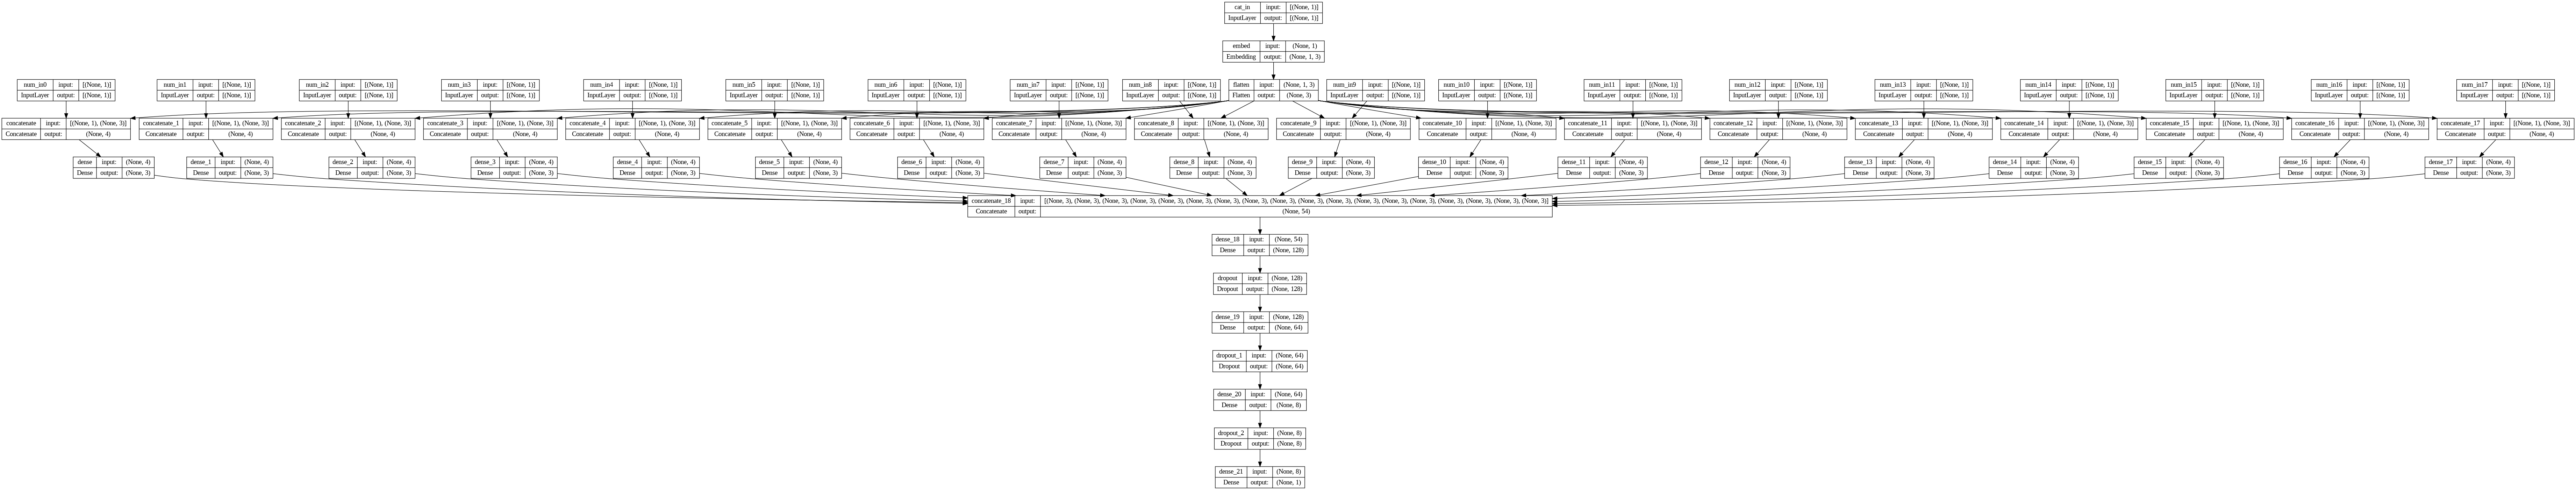

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model2, show_shapes=True)

In [ ]:
%cd /content/drive/Shareddrives/ML_Final
segmentation_model.save("seg_model1")

##Plot Performance Metrics##

In [ ]:
def plot_prediction(X, y, pred):
  fig = plt.figure(figsize=(10,4))
  ax = fig.add_subplot(121, projection='3d')
  color = ['r', 'g', 'b']
  particle = ['jets', 'positron', 'electron']
  for obj in range(3):
    x_p = X[:,:,0].reshape(n_max)[y==obj]
    y_p = X[:,:,1].reshape(n_max)[y==obj]
    z_p = X[:,:,2].reshape(n_max)[y==obj]
    ax.scatter(x_p, y_p, z_p, c=color[obj], alpha = 0.2, label=particle[obj])
  ax.legend(loc='upper right')
  ax.set_title('Truth plot')
  ax = fig.add_subplot(122,projection='3d')
  for obj in range(3):
    x_p = X[:,:,0].reshape(n_max)[pred==obj]
    y_p = X[:,:,1].reshape(n_max)[pred==obj]
    z_p = X[:,:,2].reshape(n_max)[pred==obj]
    ax.scatter(x_p, y_p, z_p, c=color[obj], alpha = 0.2, label=particle[obj])
  ax.set_title('Segmentation plot')
  fig.show()





file = test_files[0]
X = load_X_event(file)
y = load_y_event(file, isCat=False).reshape(n_max)
pred = np.argmax(segmentation_model.predict(X), axis=2).reshape(n_max)

plot_prediction(X,y,pred)

**Confusion Matrix**

In [ ]:
cm = np.zeros((5,5))
for X, y_true in test_generator:
  y_true = np.argmax(y_true, axis=2).reshape(n_max)
  y_pred = np.argmax(segmentation_model.predict(X), axis=2).reshape(n_max)
  cm += confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, ["jets", "e+", "e-", "bg", "fill"])
disp.plot()
plt.show()

**Intersection over Union**

In [ ]:
segmentation_model.evaluate(BatchLoader(test_files, 16))